#####Univariate forecasting.
#####Split the Passengers count from dataset. Then scaling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import requests

In [3]:
df = pd.read_csv('airline-passengers.csv')

In [4]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df = df.iloc[:, 1:2].values

In [13]:
np.shape(df)

(144, 1)

In [7]:
df[1]

array([118])

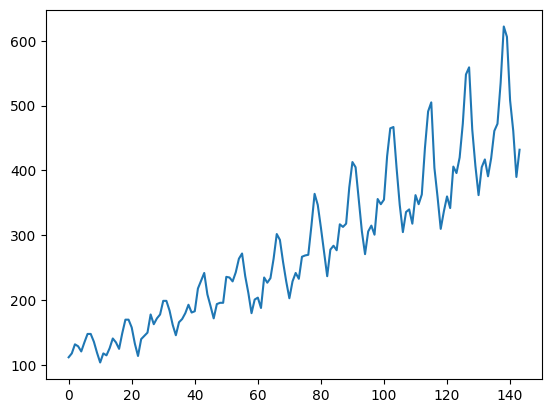

In [10]:
plt.plot(df, label='Airline Passangers Data')
plt.show()

**Sequence data arrange**

In [12]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

**Scaling to easy train**

In [17]:
sc = MinMaxScaler()
df = sc.fit_transform(df)
df[1]

array([0.02702703])

In [18]:
seq_length = 4
x, y = sliding_windows(df, seq_length)

In [19]:
print("Sequence 1:-\n",x[0])
print()
print("output for sequence 1:-\n",y[0])

Sequence 1:-
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]]

output for sequence 1:-
 [0.03281853]


In [20]:
print("Sequence 2:-\n",x[1])
print()
print("output for sequence 2:-\n",y[1])

Sequence 2:-
 [[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]

output for sequence 2:-
 [0.05984556]


**Train and Test data split**

In [21]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

**LSTM Model**

In [22]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out


**Hyber parameters**

In [23]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [24]:
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [25]:
lstm

LSTM(
  (lstm): LSTM(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

**Loss & Optimizer**

In [26]:
criterion = torch.nn.MSELoss()  # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

**Train**

In [27]:
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.50874
Epoch: 100, loss: 0.00715
Epoch: 200, loss: 0.00302
Epoch: 300, loss: 0.00279
Epoch: 400, loss: 0.00254
Epoch: 500, loss: 0.00233
Epoch: 600, loss: 0.00216
Epoch: 700, loss: 0.00205
Epoch: 800, loss: 0.00195
Epoch: 900, loss: 0.00188
Epoch: 1000, loss: 0.00182
Epoch: 1100, loss: 0.00178
Epoch: 1200, loss: 0.00176
Epoch: 1300, loss: 0.00175
Epoch: 1400, loss: 0.00175
Epoch: 1500, loss: 0.00174
Epoch: 1600, loss: 0.00174
Epoch: 1700, loss: 0.00173
Epoch: 1800, loss: 0.00172
Epoch: 1900, loss: 0.00172


**Evalution**

In [28]:
lstm.eval()
train_predict = lstm(dataX)

**Inverse to scaling**

In [45]:
data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

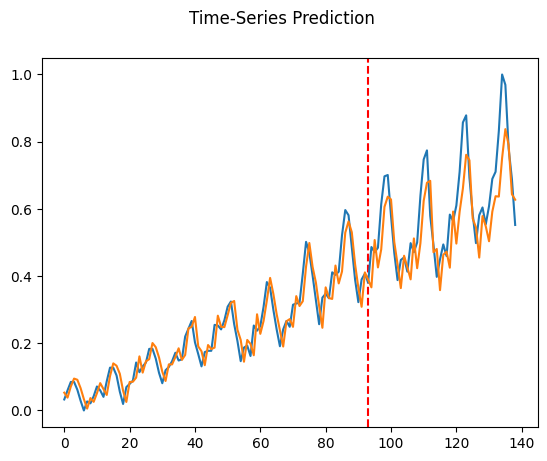

In [36]:
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()